---
---
# Example: Feature Processing Pipeline 
**AUTHOR:**   Athon Millane\
**DATE:** 28/04

---

### Contents
- 1. [Imports and data loading](#1)
- 2. [Global variables and hyperparameters](#2)
- 3. [Data processing pipeline](#3)
  - 3.1 [Data load](#3.1)
  - 3.2 [Understanding missingness](#3.2)
  - 3.3 [Splitting by feature type](#3.3)
  - 3.4 [Looking at unique values](#3.4)
  - 3.5 [Pull out binary and merge with categories](#3.5)
  - 3.6 [Scale and impute *numerical* features](#3.6)
  - 3.7 [Impute and encode *categorical* features](#3.7)
  - 3.8 [Merge together *numerical* and *categorical* features](#3.8)
  - 3.9 [Generate `df_X` and `df_y`](#3.9)
- 4. [All processing run in one cell](#4)
---

<a name="1"></a>
## 1. Imports and data loading 
Here we import all the pipeline components we'll use for preprocessing and visualisation.
- `utils.processing` contains processing functions that recieve and return a flat dataframe, with some change applied.
- `utils.vis` functions provide a **view** on the state of the dataframe, without permuting it.

Both types of functions are called in sequence using the `pandas.pipe` API, which will be demonstrated throughout this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [3]:
import sys; sys.path.append('../../src')
import pandas as pd
import matplotlib.pyplot as plt

from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap

To understand any particular function from `processing` or `vis`, simply use the cell magic `?` after the imported function name:

In [4]:
sort?

Signature: sort(df)
Docstring:
Sort features of df based on count of populated values.
    
File:      ~/Documents/PhD/COVID-19/repo/covidlib/src/utils/processing.py
Type:      function


---

<a name="2"></a>
## 2. Global variables and hyperparameters
- These are the values we may wish to change for experimentation purposes.

In [5]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# path of current data from ../../src/config file.
from config import CURRENT

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

---

<a name="3"></a>
## 3. Data processing pipeline

<a name="3.1"></a>
### 3.1 Data load
Pull in `daily` and `patients` data and merge on `pin` and `date_daily`

In [6]:
# pull in raw data
daily    = pd.read_csv(CURRENT/'daily.csv')
patients = pd.read_csv(CURRENT/'patients.csv')
patients_daily = daily.merge(patients, how='left', on='pin').set_index(['pin','date_daily']).sort_index()

#### DATA ISSUE FOUND: Multiple copies of same patient + day
**Current solution**: drop duplicates

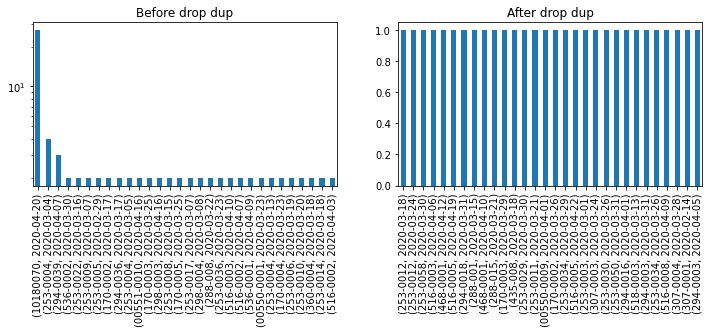

In [7]:
plt.subplots(1,2,figsize=params['figsize'])
plt.subplot(1,2,1); _=patients_daily.index.value_counts().head(30).plot.bar(logy=True, title='Before drop dup')

# drop duplicates
patients_daily = patients_daily.reset_index().drop_duplicates(subset=['pin','date_daily']).set_index(['pin','date_daily'])
plt.subplot(1,2,2); _=patients_daily.index.value_counts().head(30).plot.bar(title='After drop dup')

<a name="3.2"></a>
### 3.2 Understanding missingness

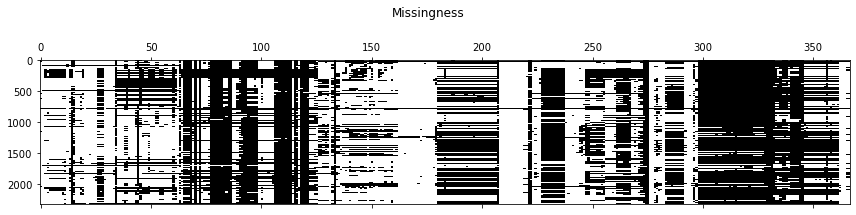

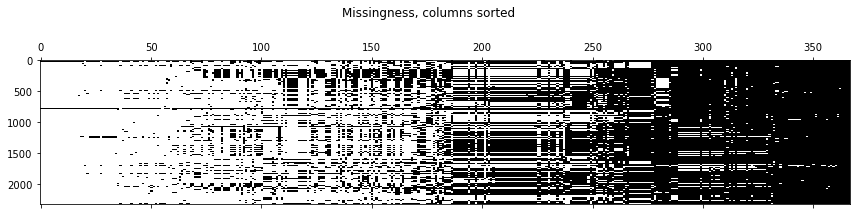

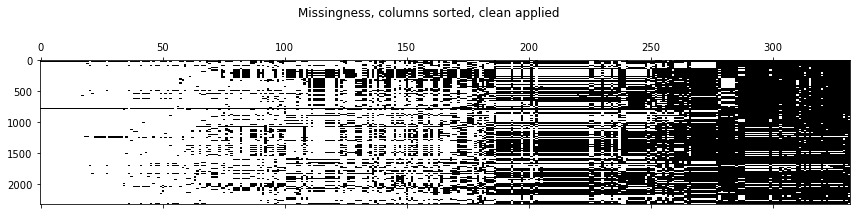

In [8]:
# look at missingness
patients_daily.pipe(spy, title='Missingness',figsize=FIGSIZE).pipe(cap)

# sort columns
patients_daily.pipe(sort).pipe(spy, title='Missingness, columns sorted', figsize=FIGSIZE).pipe(cap)

# remove unpopulated columns
patients_daily.pipe(sort)\
              .pipe(replace_inf).pipe(drop_empty)\
              .pipe(spy, title='Missingness, columns sorted, clean applied', figsize=FIGSIZE).pipe(cap)

<a name="3.3"></a>
### 3.3 Splitting by feature type

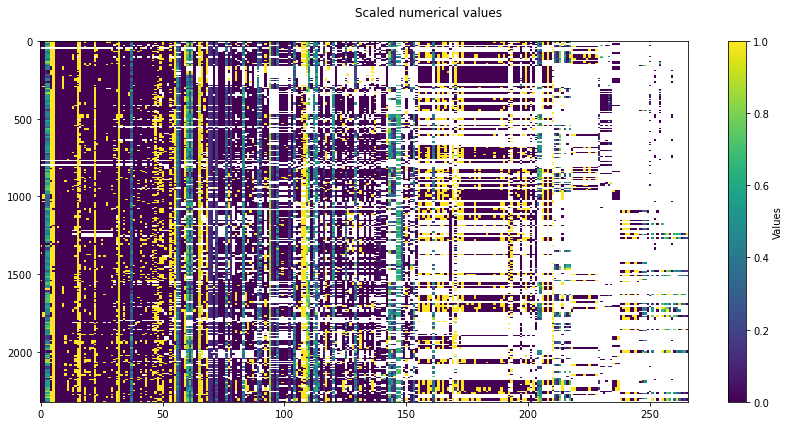

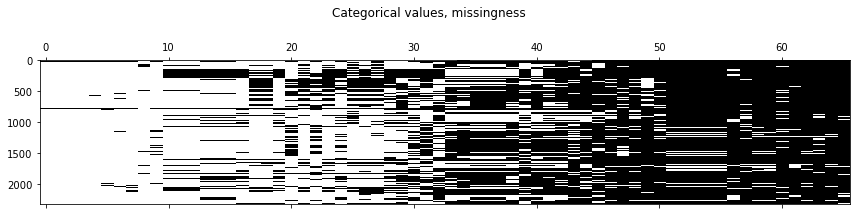

In [9]:
# split by column type
patients_daily_num = patients_daily.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical').pipe(look, title='Scaled numerical values', figsize=[12,6])
patients_daily_cat = patients_daily.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical').pipe(spy, title='Categorical values, missingness', figsize=FIGSIZE)

<a name="3.4"></a>
### 3.4 Looking at unique values

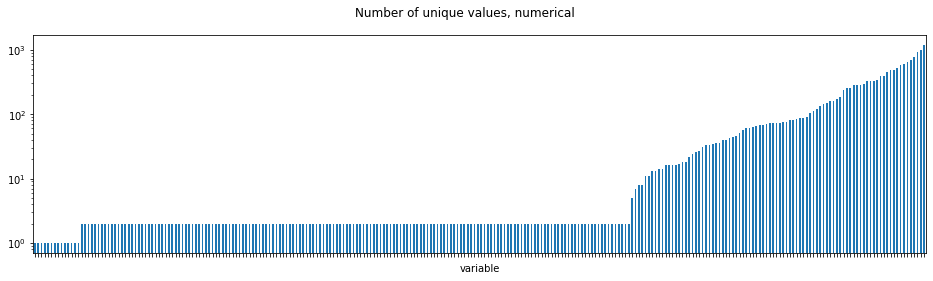

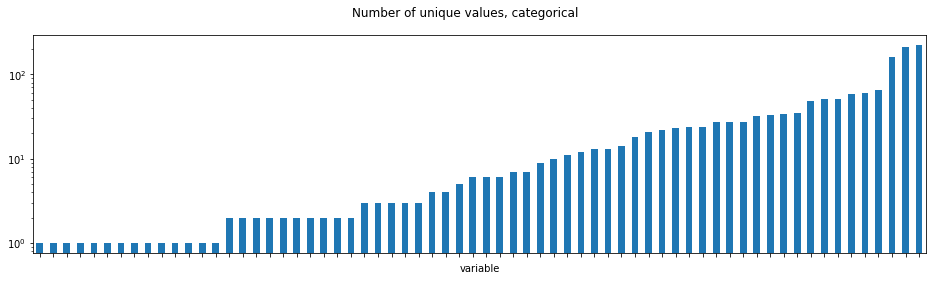

In [10]:
# check unique values
patients_daily_num.pipe(plot_nunique,title='Number of unique values, numerical').pipe(cap)
patients_daily_cat.pipe(plot_nunique,title='Number of unique values, categorical').pipe(cap)

<a name="3.5"></a>
### 3.5 Pull out binary and merge with categories

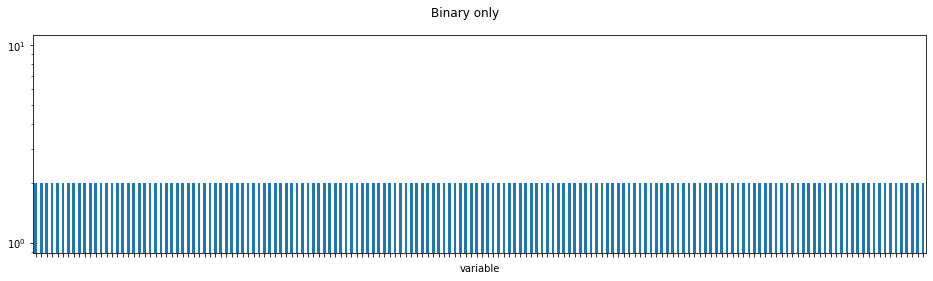

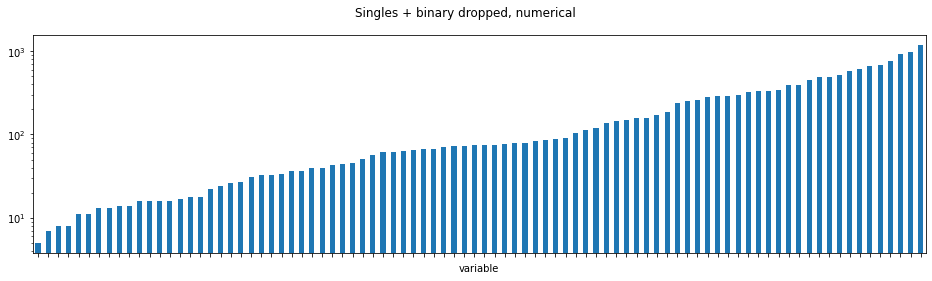

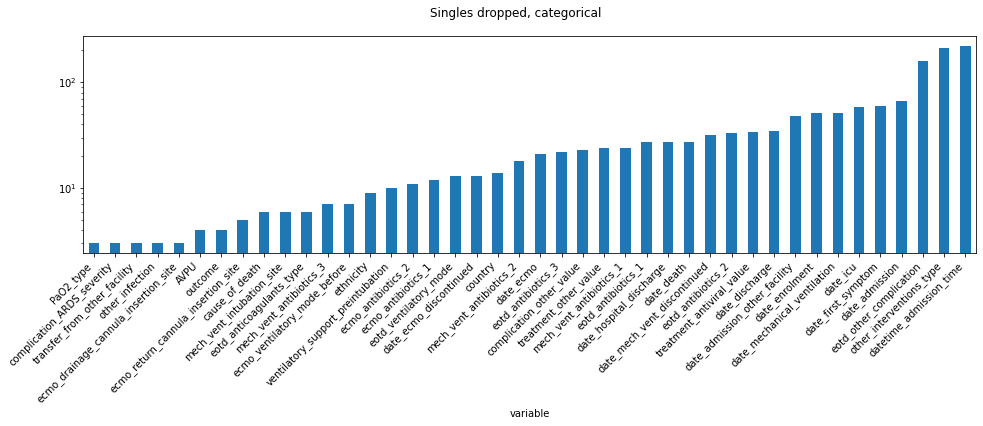

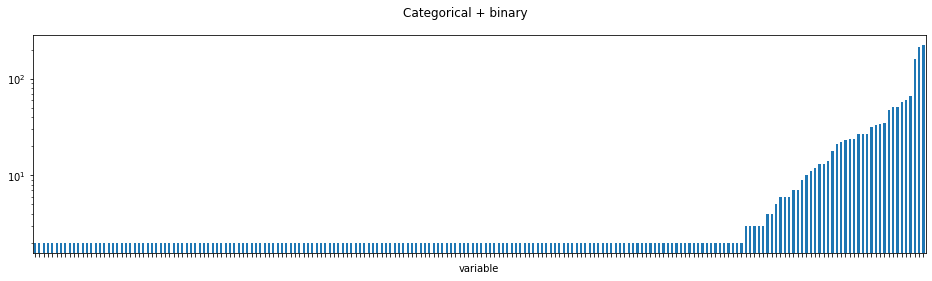

In [11]:
# pull out binary
patients_daily_binary = patients_daily_num.pipe(drop_by_nunique, 1, 2)
patients_daily_binary.pipe(plot_nunique,title='Binary only').pipe(cap)

# remove single values
patients_daily_num_ = patients_daily_num.pipe(drop_by_nunique, 2).pipe(plot_nunique,title='Singles + binary dropped, numerical')
patients_daily_cat_ = patients_daily_cat.pipe(drop_by_nunique, 2).pipe(plot_nunique,title='Singles dropped, categorical')

# merge categorical and binary together
patients_daily_cat__ = pd.merge(patients_daily_binary, patients_daily_cat_, how='inner', left_index=True, right_index=True)\
                         .pipe(plot_nunique,title='Categorical + binary')

<a name="3.6"></a>
### 3.6 Scale and impute *numerical* features

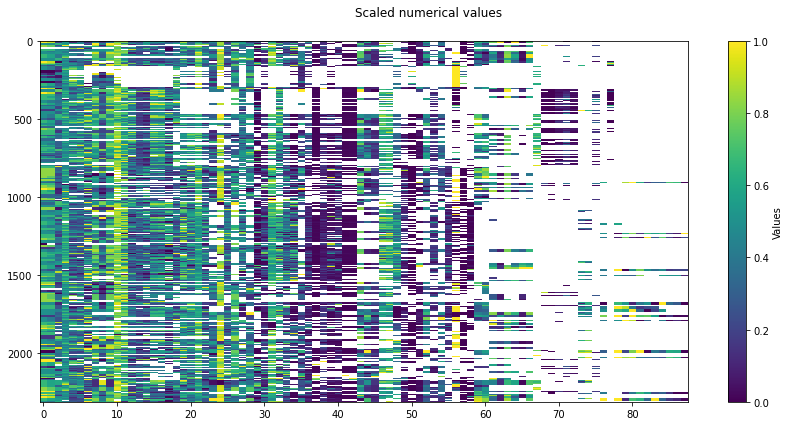

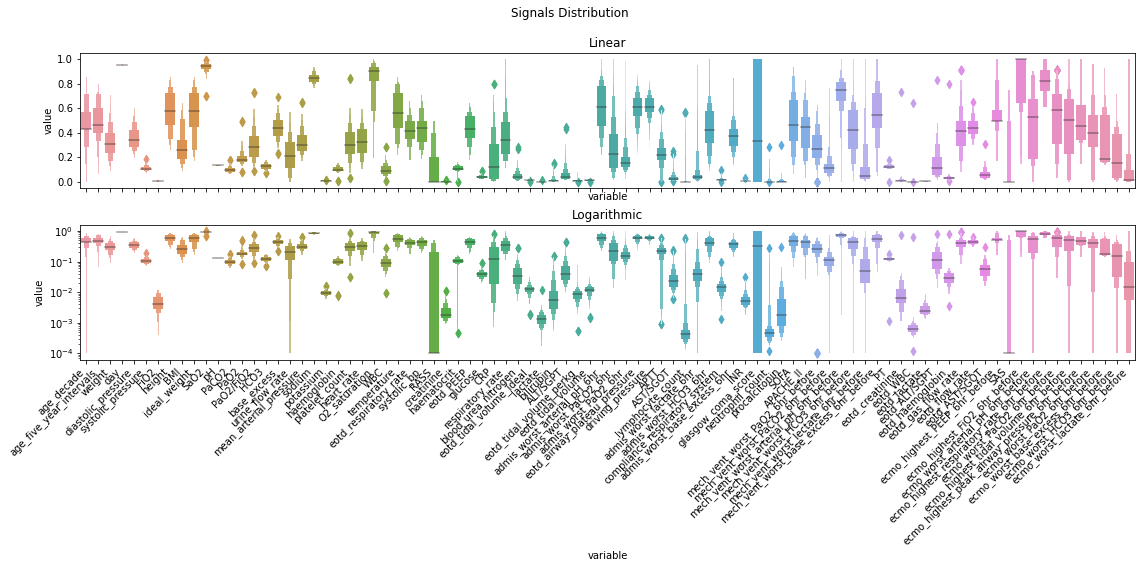

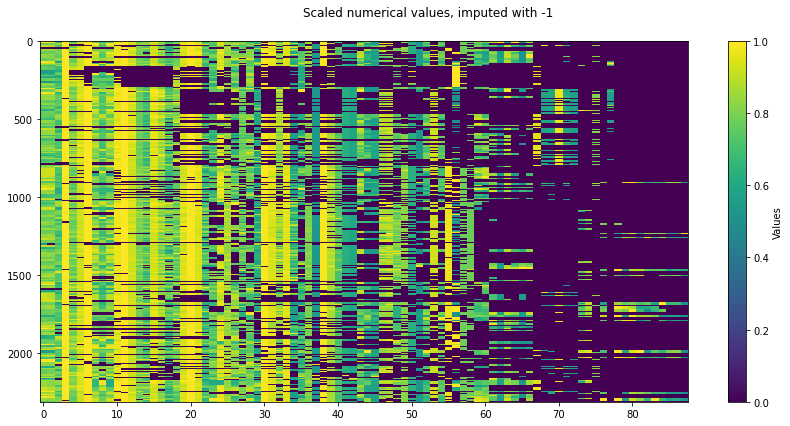

In [12]:
# numerical: [0,1] scale, remove outliers
patients_daily_num_.pipe(scale).pipe(remove_outliers)\
                   .pipe(sort).pipe(drop_empty).pipe(look, title='Scaled numerical values', figsize=[12,6]).pipe(plot_dists).pipe(cap)

# impute with -1
patients_daily_num__ = patients_daily_num_.pipe(scale).pipe(remove_outliers).pipe(sort).pipe(drop_empty).fillna(-1)\
                                          .pipe(look, title='Scaled numerical values, imputed with -1', figsize=[12,6])

<a name="3.7"></a>
### 3.7 Impute and encode *categorical* features

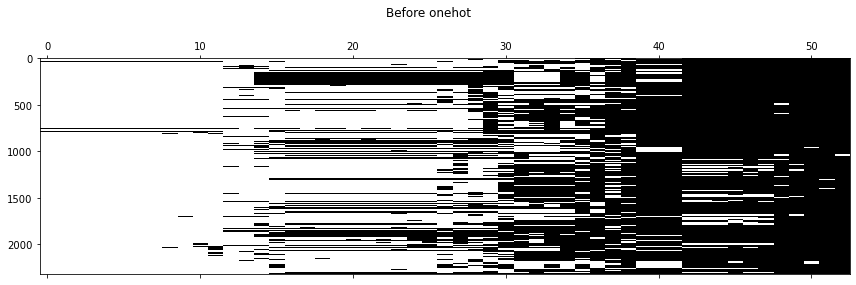

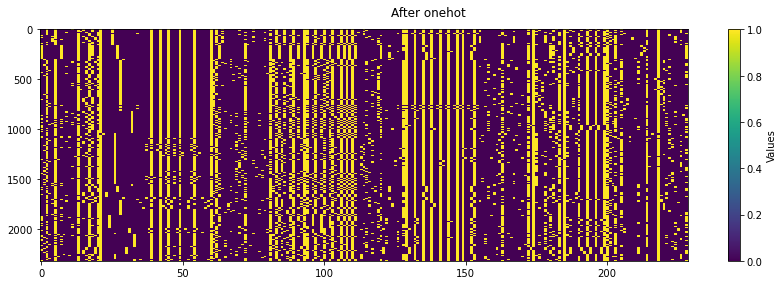

In [13]:
# cateogorical: impute NaNs as 'not_recorded', one hot encode
patients_daily_cat___ = patients_daily_cat__.pipe(get_categories).pipe(filter_categorical, cutoff=20, plot=False)\
                                            .pipe(sort).pipe(spy, title='Before onehot', figsize=[12,4])\
                                            .fillna('other').pipe(onehot).pipe(look, title='After onehot', figsize=[12,4])

<a name="3.8"></a>
### 3.8 Merge together *numerical* and *categorical* features

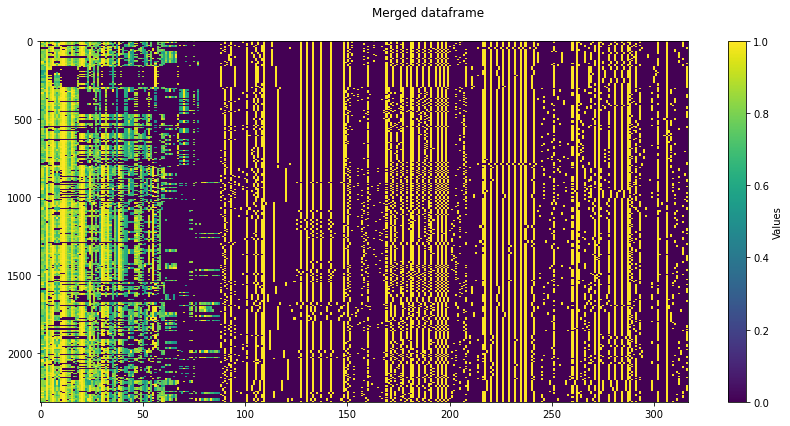

In [14]:
# merge to get processed, take a look at manifolds
processed = pd.merge(patients_daily_num__.pipe(scale), patients_daily_cat___, left_index=True, right_index=True)\
                        .pipe(look, title='Merged dataframe', figsize=[12,6])

<a name="3.9"></a>
### 3.9 Generate `df_X` and `df_y`

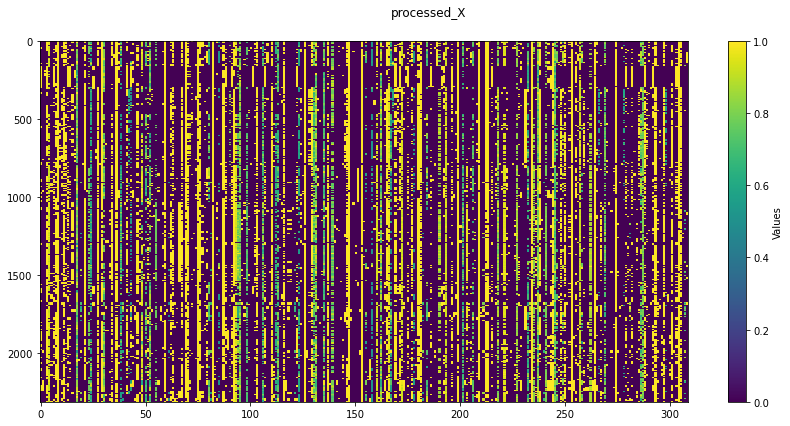

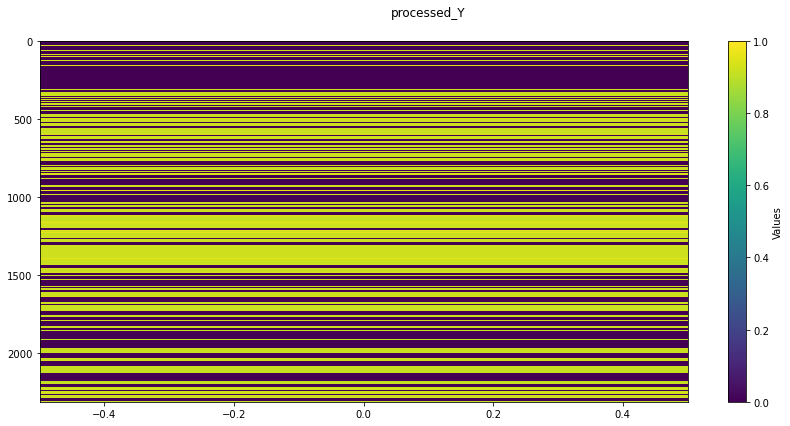

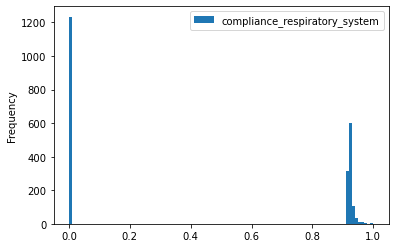

In [15]:
# create df_X and df_y
drop_X   = ['eotd_PEEP', 'ecmo_highest_PEEP_6hr_before', 
            'eotd_tidal_volume_ideal', 'eotd_tidal_volume_perkg', 'eotd_tidal_volume', 'ecmo_highest_tidal_volume_6hr_before', 
            'eotd_airway_plateau_pressure']
select_y = ['compliance_respiratory_system']

processed_X = processed.pipe(filter_regex, drop_X+select_y).pipe(look,title='processed_X', figsize=[12,6])
processed_Y = processed.filter(regex='|'.join(select_y)).pipe(look,title='processed_Y', figsize=[12,6])
_=processed_Y.plot.hist(bins=100)

- In this example, we want to use unprocessed y values (without [0,1] scaling, and with empty values removed, rather than imputed), so we can simply process them in their own pipeline, direct from the raw data.

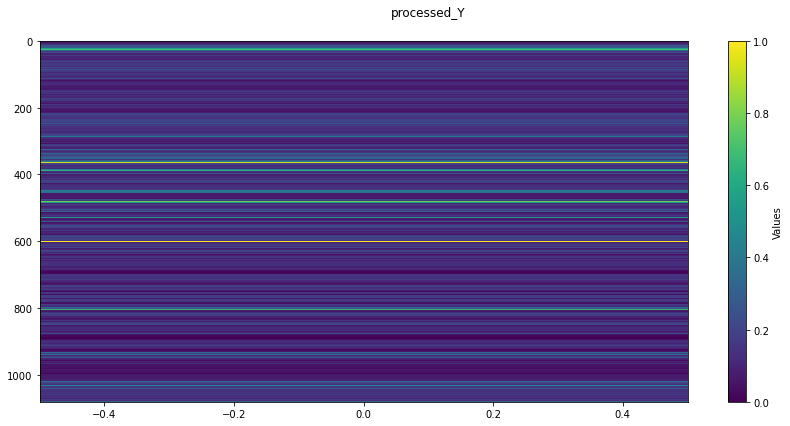

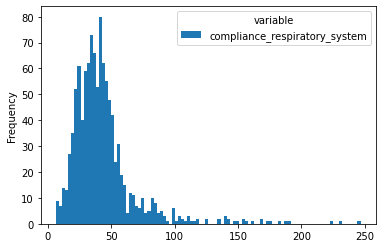

In [16]:
raw_Y = patients_daily.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers).pipe(look,title='processed_Y', figsize=[12,6])
raw_Y.plot.hist(bins=100)

- Finally, we set our `df_y` to be these newly processed values, and ensure they are matched on patient and date using `match`.

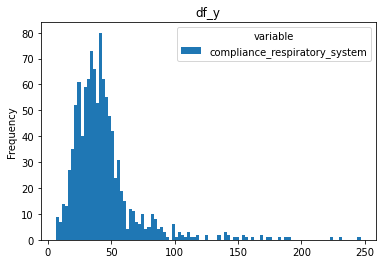

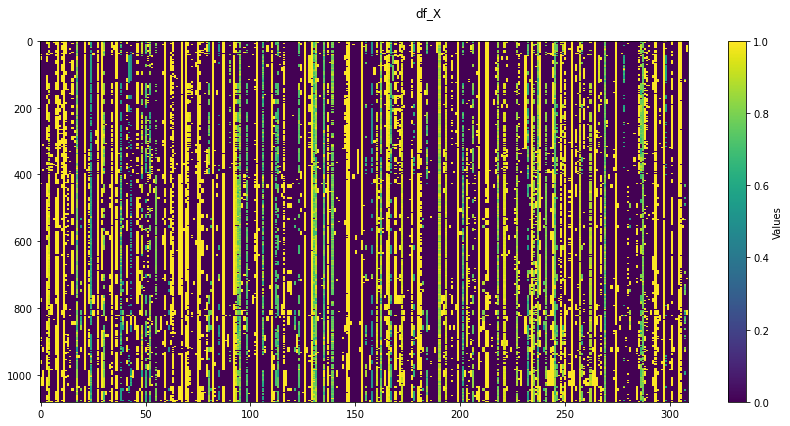

In [17]:
# choose df_y
df_y = raw_Y[['compliance_respiratory_system']]
df_y = df_y[df_y > 0]
df_y.plot.hist(bins=100, title='df_y')

# match values in df_X from df_y
df_X, df_y = match(processed_X, df_y)

# visualise new X
df_X.pipe(look,title='df_X',figsize=[12,6]).pipe(cap)

<a name="4"></a>
## 4. All processing run in one cell (without `vis`)

In [18]:
import sys; sys.path.append('../../src')
import pandas as pd
import matplotlib.pyplot as plt

from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap

# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

DROP_X     = ['eotd_PEEP', 'ecmo_highest_PEEP_6hr_before', 
              'eotd_tidal_volume_ideal', 'eotd_tidal_volume_perkg', 'eotd_tidal_volume', 'ecmo_highest_tidal_volume_6hr_before', 
              'eotd_airway_plateau_pressure']
SELECT_Y   = ['compliance_respiratory_system']

# path of current data from ../../src/config file.
from config import CURRENT

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

# processing
daily    = pd.read_csv(CURRENT/'daily.csv')
patients = pd.read_csv(CURRENT/'patients.csv')
patients_daily = daily.merge(patients, how='left', on='pin').set_index(['pin','date_daily']).sort_index()\
                      .reset_index().drop_duplicates(subset=['pin','date_daily']).set_index(['pin','date_daily'])\
                      .pipe(sort).pipe(replace_inf).pipe(drop_empty)

# numerical processing
patients_daily_num = patients_daily.pipe(select,'numerical').pipe(drop_by_nunique, 2)\
                                   .pipe(scale).pipe(remove_outliers).pipe(sort).pipe(drop_empty)\
                                   .fillna(-1)

# categorical processing
patients_daily_binary = patients_daily_num.pipe(select,'numerical').pipe(drop_by_nunique, 1, 2)
patients_daily_cat = patients_daily.pipe(select, 'categorical').pipe(drop_by_nunique, 2)
patients_daily_cat = pd.merge(patients_daily_binary, patients_daily_cat, how='inner', left_index=True, right_index=True)
patients_daily_cat = patients_daily_cat.pipe(get_categories).pipe(filter_categorical, cutoff=20, plot=False)\
                                       .pipe(sort).fillna('other').pipe(onehot)

# merge numerical and categorical
processed = pd.merge(patients_daily_num.pipe(scale), patients_daily_cat, left_index=True, right_index=True)
processed_X = processed.pipe(filter_regex, DROP_X+SELECT_Y)
processed_Y = processed.filter(regex='|'.join(SELECT_Y))
raw_Y = patients_daily.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(SELECT_Y)).pipe(remove_outliers)
df_y = raw_Y[SELECT_Y]

# specific to this particular experiment
df_y = df_y[df_y > 0]

# match df_X and df_y
df_X, df_y = match(processed_X, df_y)

---
---